imports etc...

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom
import imageio

def paralleltomo(*args):
#PARALLELTOMO Creates a 2D tomography system matrix using parallel beams
#
#   [A,theta,p,d] = paralleltomo(N)
#   [A,theta,p,d] = paralleltomo(N,theta)
#   [A,theta,p,d] = paralleltomo(N,theta,p)
#   [A,theta,p,d] = paralleltomo(N,theta,p,d)
#
# This function creates a 2D tomography test problem with an N-times-N
# domain, using p parallel rays for each angle in the vector theta.
#
# Input: 
#   N           Scalar denoting the number of discretization intervals in 
#               each dimesion, such that the domain consists of N^2 cells.
#   theta       Vector containing the angles in degrees. Default: theta = 
#               0:1:179.
#   p           Number of parallel rays for each angle. Default: p =
#               round(sqrt(2)*N).
#   d           Scalar denoting the distance from the first ray to the last.
#               Default: d = sqrt(2)*N.
#
# Output:
#   A           Coefficient matrix with N^2 columns and nA*p rows, 
#               where nA is the number of angles, i.e., length(theta).
#   theta       Vector containing the used angles in degrees.
#   p           The number of used rays for each angle.
#   d           The distance between the first and the last ray.
# 
# See also: fanbeamtomo, seismictomo.

#Anders Nymark Christensen, 20180216, DTU Compute
#Revised from the matlab version by:
    
# Jakob Sauer Jørgensen, Maria Saxild-Hansen and Per Christian Hansen,
# October 1, 201r, DTU Compute.

# Reference: A. C. Kak and M. Slaney, Principles of Computerized 
# Tomographic Imaging, SIAM, Philadelphia, 2001.
    

    import numpy as np
    from scipy.sparse import csr_matrix
    
    N = args[0]

        
    # Default value of d.
    if len(args) < 4:
        d = np.sqrt(2)*N
    else:
        d = args[3]
    
    # Default value of the number of rays.
    if len(args) < 3:
        p = int(round(np.sqrt(2)*N))
    else:
        p = args[2]

    # Default value of the angles theta.
    if len(args) < 2:
        theta = np.matrix(np.arange(0.,180.))
    else:
        theta = args[1]


    # Define the number of angles.
    nA = theta.shape[1]

    # The starting values both the x and the y coordinates. 
    x0 = np.matrix(np.linspace(-d/2,d/2,p)).T
    y0 = np.matrix(np.zeros([p,1]))

    # The intersection lines.
    x = np.matrix(np.arange(-N/2,N/2 + 1)).T
    y = np.copy(x)

    # Initialize vectors that contains the row numbers, the column numbers and
    # the values for creating the matrix A effiecently.
    rows = np.matrix(np.zeros([2*N*nA*p,1]))
    cols = np.copy(rows)
    vals = np.copy(rows)
    idxend = 0


    # Loop over the chosen angles.
    for i in range(0,nA):
                
        # All the starting points for the current angle.
        x0theta = np.cos(np.deg2rad(theta[0,i]))*x0-np.sin(np.deg2rad(theta[0,i]))*y0
        y0theta = np.sin(np.deg2rad(theta[0,i]))*x0+np.cos(np.deg2rad(theta[0,i]))*y0
        
        # The direction vector for all the rays corresponding to the current 
        # angle.
        a = -np.sin(np.deg2rad(theta[0,i]))
        b = np.cos(np.deg2rad(theta[0,i]))
        
        # Loop over the rays.
        for j in range(0,p):
            
            # Use the parametrisation of line to get the y-coordinates of
            # intersections with x = k, i.e. x constant.
            tx = (x - x0theta[j,0])/a
            yx = b*tx + y0theta[j,0]
            
            # Use the parametrisation of line to get the x-coordinates of
            # intersections with y = k, i.e. y constant.
            ty = (y - y0theta[j,0])/b
            xy = a*ty + x0theta[j,0]            
            
            # Collect the intersection times and coordinates. 
            t = np.vstack([tx, ty])
            xxy = np.vstack([x, xy])
            yxy = np.vstack([yx, y])
            
            # Sort the coordinates according to intersection time.
            I = np.argsort(t,0)
            xxy = xxy[I]
            yxy = yxy[I]        
            
            # Skip the points outside the box.
            I1 = np.logical_and(np.array(xxy) >= -N/2 , np.array(xxy) <= N/2)
            I2 = np.logical_and(np.array(yxy) >= -N/2 , np.array(yxy) <= N/2)
            I = np.squeeze(np.logical_and(I1,I2))
            #I = (xxy >= -N/2 & xxy <= N/2 & yxy >= -N/2 & yxy <= N/2)
            xxy = np.squeeze(xxy[I])
            yxy = np.squeeze(yxy[I])
            
            # Skip double points.
            I = np.logical_and(abs(np.diff(xxy)) <= 1e-10 , abs(np.diff(yxy)) <= 1e-10)
            if np.not_equal(I.size, 0):
                I = np.concatenate((I, np.matrix([False])), axis=1)
            xxy = xxy[~I]
            yxy = yxy[~I]
#            xxy = np.delete(xxy,I)
#            yxy = np.delete(yxy,I)
            
            # Calculate the length within cell and determines the number of
            # cells which is hit.
            d = np.sqrt(np.power(np.diff(xxy),2) + np.power(np.diff(yxy),2))
            numvals = d.shape[1]
            
            # Store the values inside the box.
            if numvals > 0:
                
                # If the ray is on the boundary of the box in the top or to the
                # right the ray does not by definition lie with in a valid cell.
                if not ((b == 0 and abs(y0theta[j,0] - N/2) < 1e-15) or (a == 0 and abs(x0theta[j,0] - N/2) < 1e-15)):
                    
                    # Calculates the midpoints of the line within the cells.
                    xm = 0.5*(xxy[0,0:-1]+xxy[0,1:]) + N/2
                    ym = 0.5*(yxy[0,0:-1]+yxy[0,1:]) + N/2
                    
                    # Translate the midpoint coordinates to index.
                    col = np.floor(xm)*N + (N - np.floor(ym)) - 1
                    
                    # Create the indices to store the values to vector for
                    # later creation of A matrix.
                    idxstart = idxend
                    idxend = idxstart + numvals
                    idx = np.arange(idxstart,idxend)
                    
                    # Store row numbers, column numbers and values. 
                    rows[idx,0] = i*p + j
                    cols[idx,0] = col[0,:]
                    vals[idx,0] = d  


    # Truncate excess zeros.
    rows = rows[0:idxend]
    cols = cols[0:idxend]
    vals = vals[0:idxend]
    
    # Create sparse matrix A from the stored values.
    A = csr_matrix((vals[:,0].astype(np.float), (np.squeeze(np.array(rows[:,0]).astype(int)), np.squeeze(np.array(cols[:,0]).astype(int)))), dtype=np.float, shape=(p*nA, N**2)).toarray()

    
    return [A,theta,p,d]


Other necessary functions/variables

In [2]:
def forwardProj(A, x):
    return np.matmul(A, x)

def solveForX(A, b):
    return np.linalg.lstq(A, b)

# See default arguments for plank_phantom.py
# Max wood attenuation coefficient (in rings) is assumed to be 0.322+0.1 - can be altered accordingly


def convertToAttCoeff(grayscale_im):
    """
    Converts a grayscale image to an array of attenuation coefficients
    - Numpy array -> Numpy array
    """
    grayScaleToAttCoeff = lambda x: (x/255)*0.422
    cFunc = np.vectorize(grayScaleToAttCoeff)
    return cFunc(grayscale_im)

Loading image and comparing slices

C:\Users\miles\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  This is separate from the ipykernel package so we can avoid doing imports until


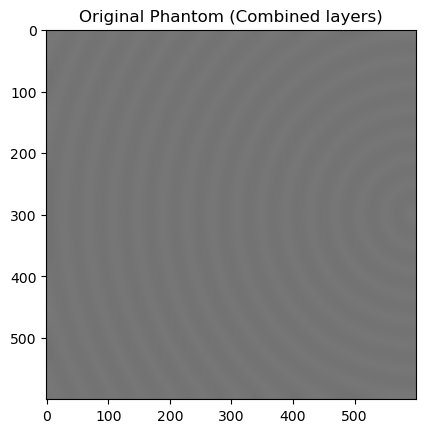

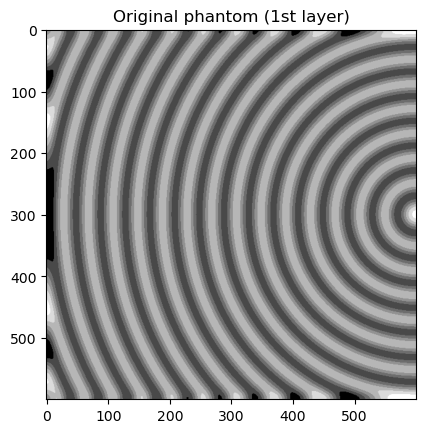

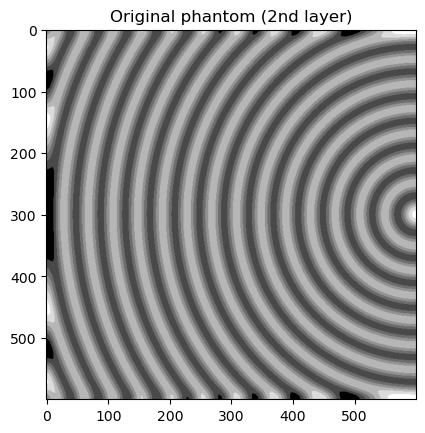

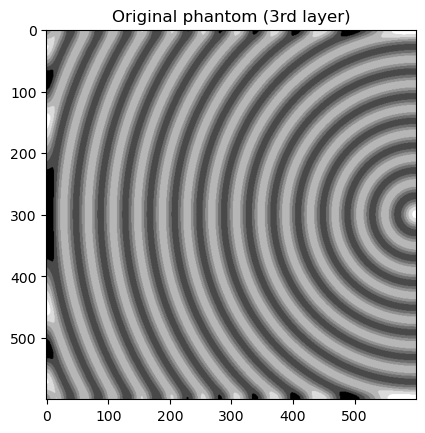

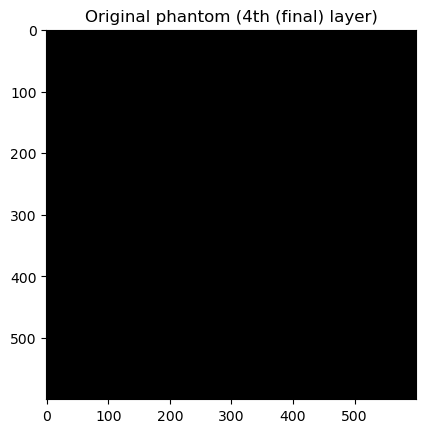

Shape of original phantom: (600, 600, 4)


In [3]:
filename = "phantom_width2.0_size(30,30,30)_angle0.0_blur10.png"
folder = r"test-phantoms\\"
img = imageio.imread(folder+filename)

# Converting to numpy array
im_array = np.array(img)
plt.imshow(im_array)
plt.title("Original Phantom (Combined layers)")
plt.show()
plt.imshow(im_array[:, :, 0], cmap="gray")
plt.title("Original phantom (1st layer)")
plt.show()
plt.imshow(im_array[:, :, 1], cmap="gray")
plt.title("Original phantom (2nd layer)")
plt.show()
plt.imshow(im_array[:, :, 2], cmap="gray")
plt.title("Original phantom (3rd layer)")
plt.show()
plt.imshow(im_array[:, :, 3], cmap="gray")
plt.title("Original phantom (4th (final) layer)")
plt.show()
print(f"Shape of original phantom: {im_array.shape}")

### Examining difference between layers

In [4]:
print(f"Difference between 1st and 2nd layer: {np.mean(np.square(im_array[:,:,0]-im_array[:,:,1]))}")
print(f"Difference between 1st and 3rd layer: {np.mean(np.square(im_array[:,:,0]-im_array[:,:,2]))}")
print(f"Difference between 2nd and 3rd layer: {np.mean(np.square(im_array[:,:,1]-im_array[:,:,2]))}")

Difference between 1st and 2nd layer: 0.0
Difference between 1st and 3rd layer: 0.0
Difference between 2nd and 3rd layer: 0.0


### Examining final layer

In [5]:
print(im_array[:,:,-1])
print(f"mean value in final layer: {np.mean(im_array[:,:,-1])}")

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
mean value in final layer: 255.0


### Converting image from grayscale values to attenuation coefficients

In [6]:
im_array
im_array_AC = convertToAttCoeff(im_array[:,:,0])
im_array_AC.shape, im_array[:,:,0].shape

((600, 600), (600, 600))

Text(0.5, 1.0, 'Phantom after converting grayscale values to attenuation coefficients (1st layer)')

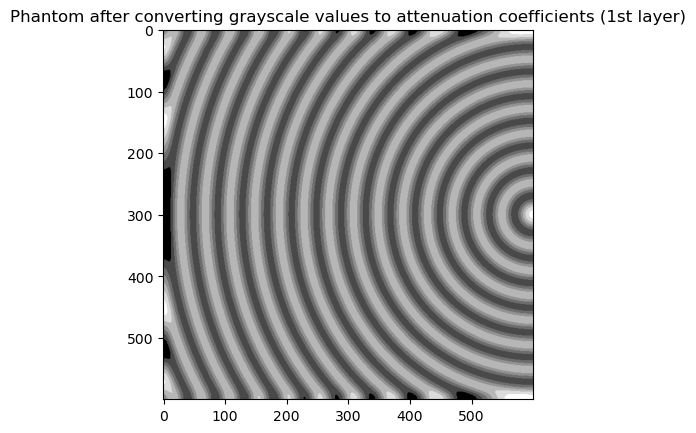

In [7]:
plt.imshow(im_array_AC, cmap="gray")
plt.title("Phantom after converting grayscale values to attenuation coefficients (1st layer)")

### Resizing images (using list slicing and bilinear interpolation) and comparing the two methods

Resized image shape (using bilinear interpolation): (50, 50)
Resized image shape (using regular resizing method): (50, 50)


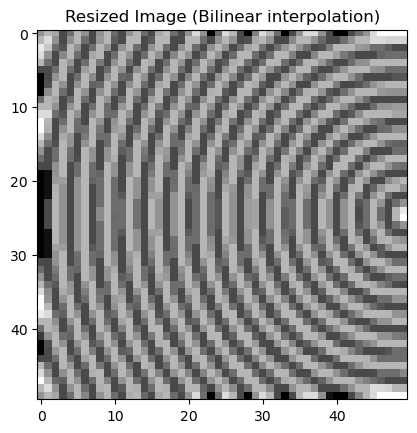

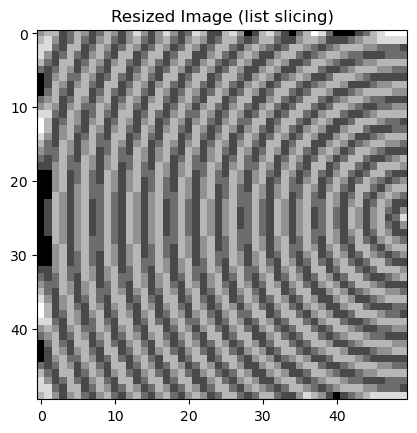

Shape of resized image: (50, 50)
Mean value of pixels in resized image (should be equal to ~attenuation coefficient for wood): 0.19288356698434478
Measurement of difference between two resizing methods: 2.0361278751796242e-06


In [8]:

# Defining resizing factor

prev_size = im_array_AC.shape[0]
new_size = 50 
factor = new_size/prev_size

resized_im = zoom(im_array_AC, (factor, factor), order=1, mode = "grid-constant") # Using Bilinear Interpolation on first layer
resized_im2 = im_array_AC[::12, ::12] # Using regular resizing method

print(f"Resized image shape (using bilinear interpolation): {resized_im.shape}")
print(f"Resized image shape (using regular resizing method): {resized_im2.shape}")




plt.imshow(resized_im, cmap="gray")
plt.title("Resized Image (Bilinear interpolation)")
plt.show()

plt.imshow(resized_im2, cmap="gray")
plt.title("Resized Image (list slicing)")
plt.show()

x = np.ravel(resized_im)
print(f"Shape of resized image: {resized_im.shape}")
print(f"Mean value of pixels in resized image (should be equal to ~attenuation coefficient for wood): {np.mean(x)}")

print(f"Measurement of difference between two resizing methods: {np.mean(np.square(resized_im-resized_im2))}")

List slicing and bilinear interpolation appear to generate essentially identical images, in this case.

In [9]:
# Set up with standard parameters
N, p = 75, 175
theta = np.matrix(np.arange(0.,180., 50))
A = paralleltomo(N, theta, p)

C:\Users\miles\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:107: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\miles\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:179: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
